# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [99]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [100]:
sys.path.insert(0, "../src")

In [101]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors

## Load data

Define the range of possible coefficient values to explore.

In [149]:
coefficients = np.linspace(-3, 3, 21)

In [150]:
delta_time = 1.0
l1_lambda = 0.001

In [151]:
last_timepoint = pd.to_datetime("2014-10-01")

In [152]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [153]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ne", "delta_frequency", "frequency"]].copy()

In [154]:
X = X[X["timepoint"] <= last_timepoint]

In [155]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ne,delta_frequency,frequency
0,A/Aichi/222/2009,ca7ba25,2009-10-01,0.905674,1.171051,9,5,0.145239,0.004845
1,A/Algeria/G202/2009,fd5868f,2009-10-01,-1.110484,-0.718868,4,5,-0.500761,0.000015
2,A/Argentina/7646/2009,5ea83cf,2009-10-01,-0.788873,-1.385935,4,5,-1.608531,0.006527
3,A/Astrakhan/7/2009,5ea83cf,2009-10-01,-1.110484,-0.348038,4,4,-1.608531,0.009280
4,A/Australia/30/2009,4f8826d,2009-10-01,0.683366,0.268793,7,4,1.030983,0.000535


In [156]:
X.shape

(1495, 9)

In [157]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [158]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2009-10-01,ca7ba25,2010-10-01,NaN,0.000000
1,2009-10-01,fd5868f,2010-10-01,NaN,0.000000
2,2009-10-01,5ea83cf,2010-10-01,A/Sydney/DD2-02/2010,0.000554
3,2009-10-01,4f8826d,2010-10-01,A/Afghanistan/2950/2009,0.000001
4,2009-10-01,4f8826d,2010-10-01,A/Alabama/5/2010,0.014053


In [159]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

In [160]:
y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

In [161]:
y = y[y["timepoint"] <= last_timepoint]

In [162]:
y.head()

,timepoint,clade_membership,frequency
0,2009-10-01,0818a58,0.0
1,2009-10-01,10b53cd,0.0
2,2009-10-01,155c578,0.0
3,2009-10-01,1c3e334,0.0
4,2009-10-01,3981529,0.0


In [163]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2009-10-01    0.999999
2010-04-01    1.000004
2010-10-01    0.999994
2011-04-01    0.999997
2011-10-01    0.999995
2012-04-01    1.000009
2012-10-01    0.970947
2013-04-01    1.000002
2013-10-01    1.000005
2014-04-01    0.999998
2014-10-01    0.996246
Name: frequency, dtype: float64

## Inspect LBI model

In [164]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [165]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

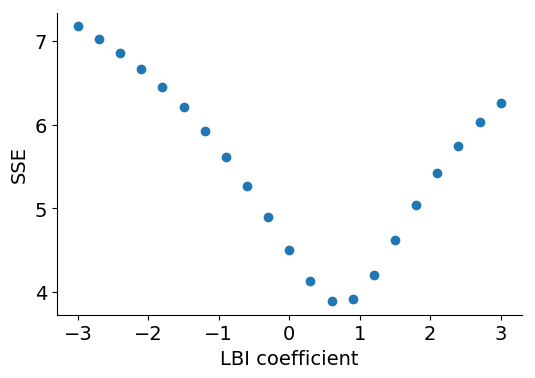

In [166]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

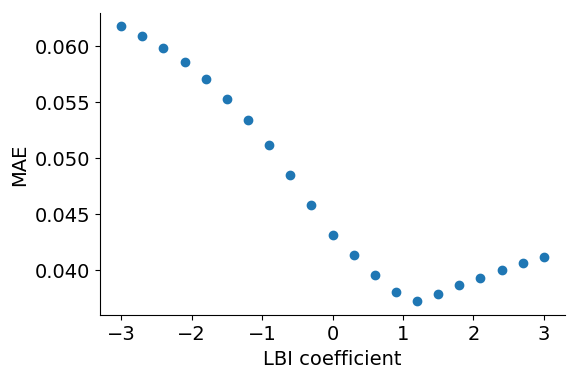

In [167]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

## Inspect cTiterSub model

In [168]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [169]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

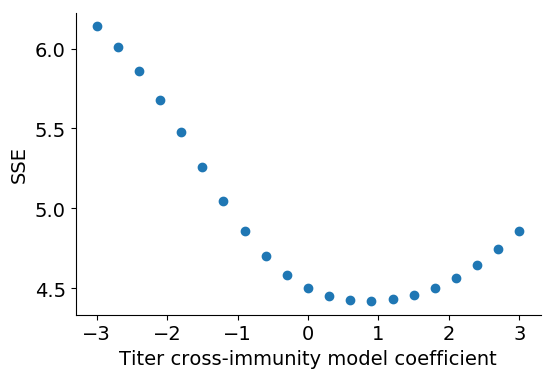

In [170]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

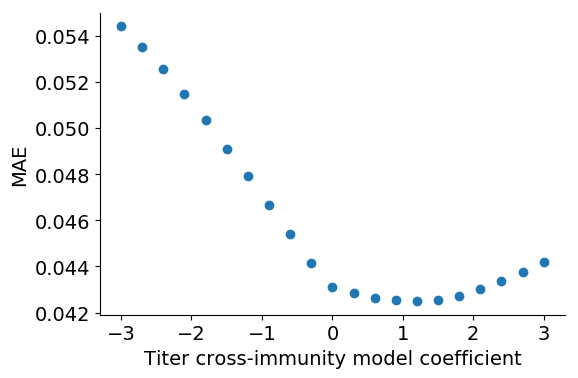

In [171]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [172]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [173]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

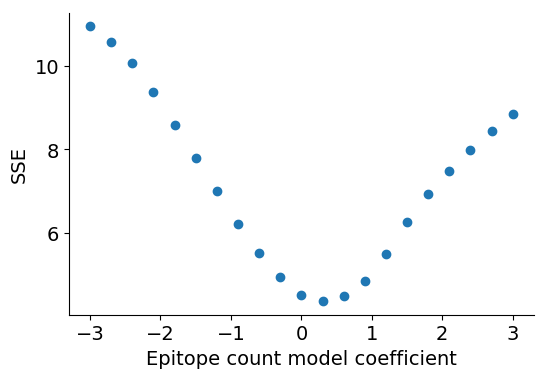

In [174]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

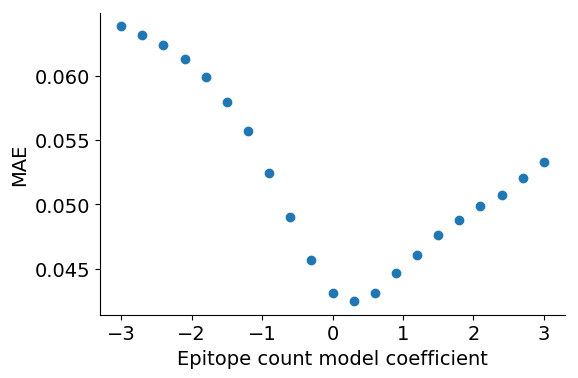

In [175]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect delta frequency model

In [176]:
predictors = ["delta_frequency"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

In [177]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'MAE')

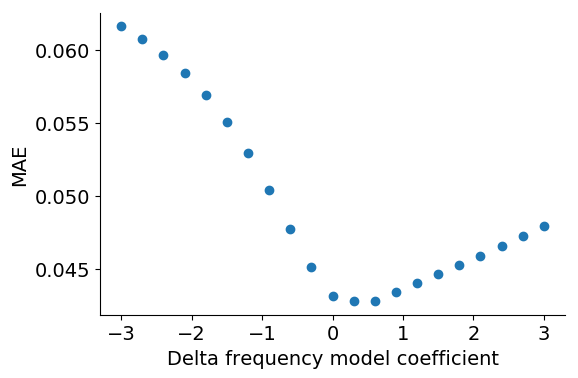

In [178]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [179]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [180]:
len(coefficients)

21

In [181]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

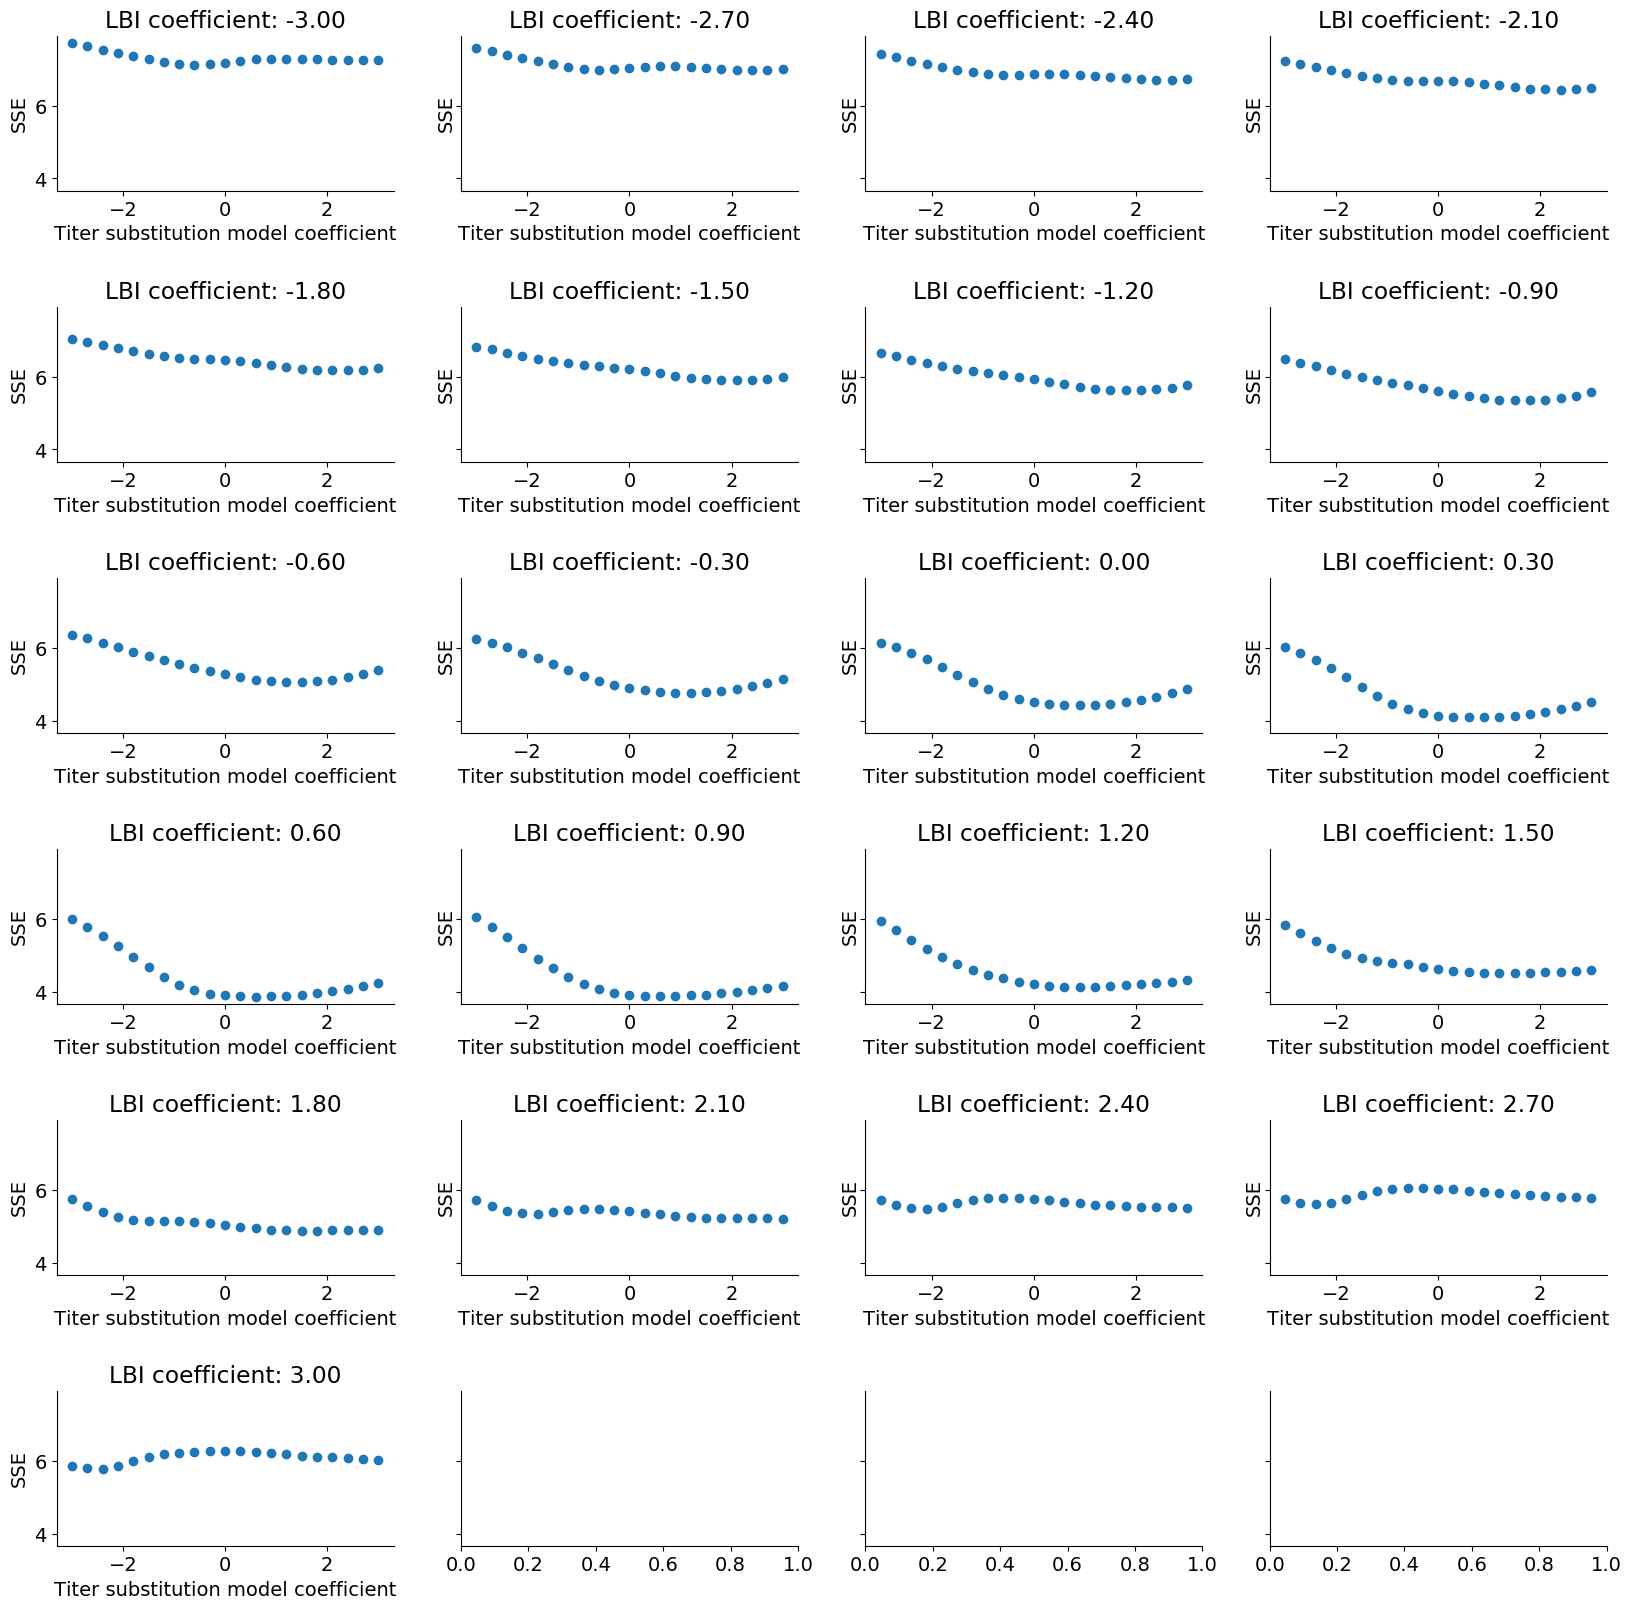

In [182]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [183]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [184]:
records_df = pd.DataFrame(records)

In [185]:
records_df.sort_values("error").head()

,cTiterSub,error,lbi
400,-2.7,0.035382,2.7
421,-2.7,0.035484,3.0
401,-2.4,0.035544,2.7
380,-2.4,0.035546,2.4
422,-2.4,0.035682,3.0


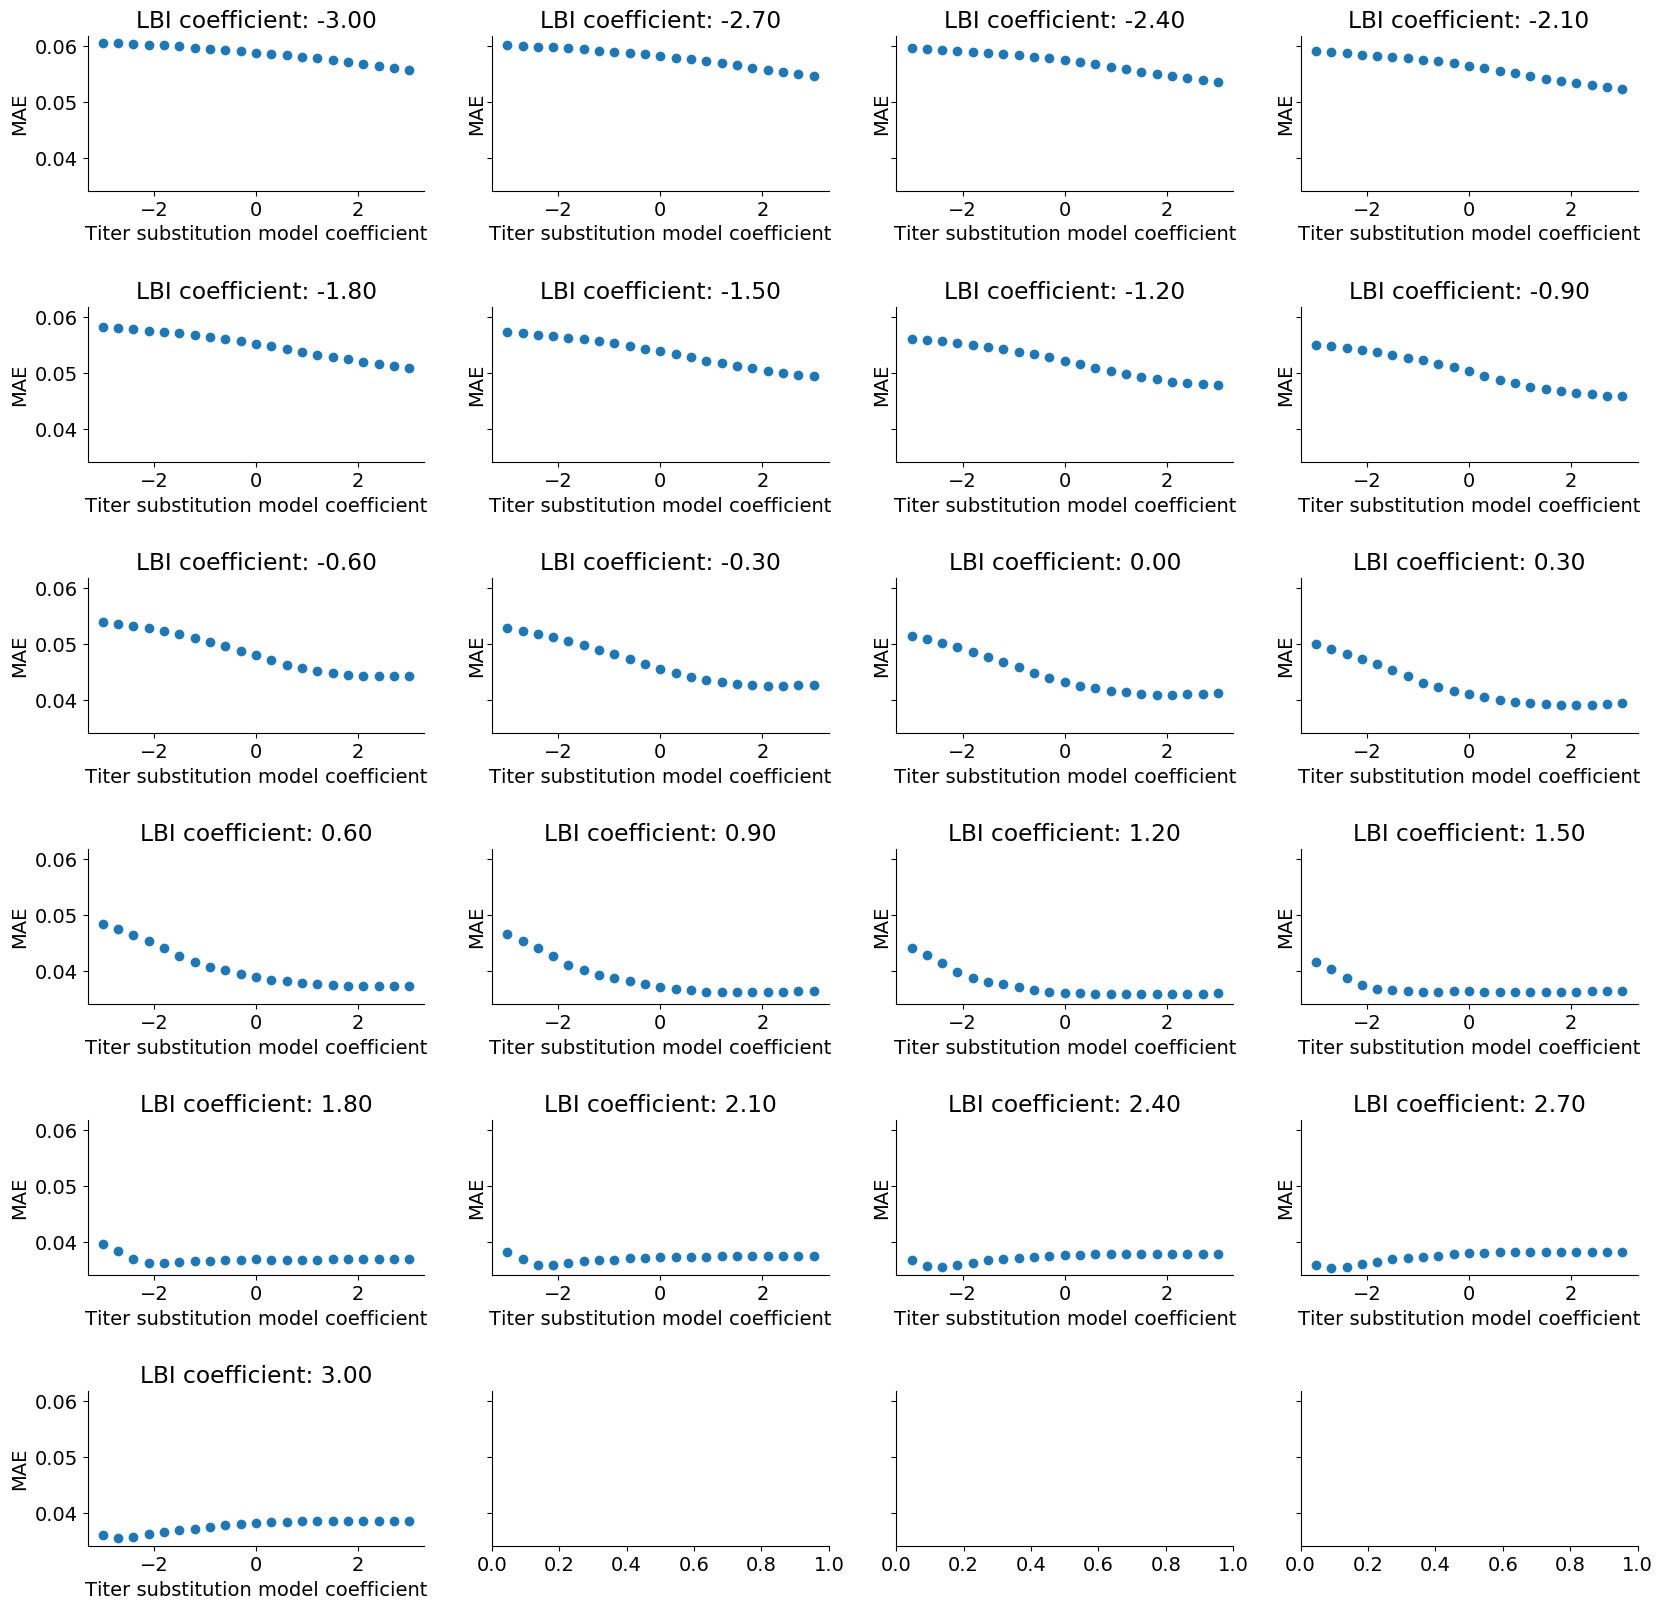

In [186]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)